In [101]:
# -----------------------------------
# Step 1: Import Required Libraries
# -----------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Set Seaborn style
sns.set(style="whitegrid")

In [102]:
# -----------------------------------
# Step 2: Load and Explore the Dataset
# -----------------------------------
df = pd.read_csv("insurance_claim_approval.csv")
print(df.head())             # Show first 5 rows
print(df.shape)              # Shape of the dataset
print(df.info())             # Data types and nulls
print(df.isnull().sum())     # Check for missing values

# Unique values per column
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Descriptive statistics for numeric columns
print(df.describe())

# Claim_Approved distribution
print(df['Claim_Approved'].value_counts(normalize=True) * 100)

   Age  Gender   BMI Smoking  ... Previous_Insurance  Annual_Premium Policy_Sales_Channel  Claim_Approved
0   56    Male  36.8     Yes  ...                  1        45611.28          Call Center               0
1   69    Male  29.1      No  ...                  1        52144.80          Call Center               0
2   46    Male  28.8     Yes  ...                  0        21597.37                Agent               0
3   32  Female  31.2      No  ...                  0        22184.99               Online               0
4   60    Male  36.2      No  ...                  0        50553.75          Call Center               0

[5 rows x 11 columns]
(1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1000 non-null   int64  
 1   Gender                1000 non-null   object 
 2   BMI            

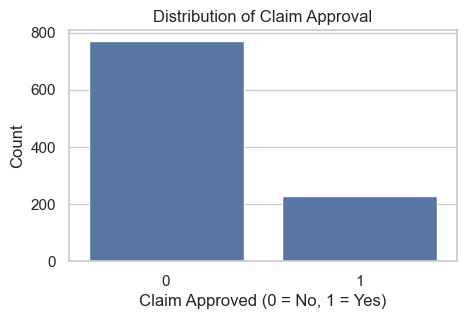

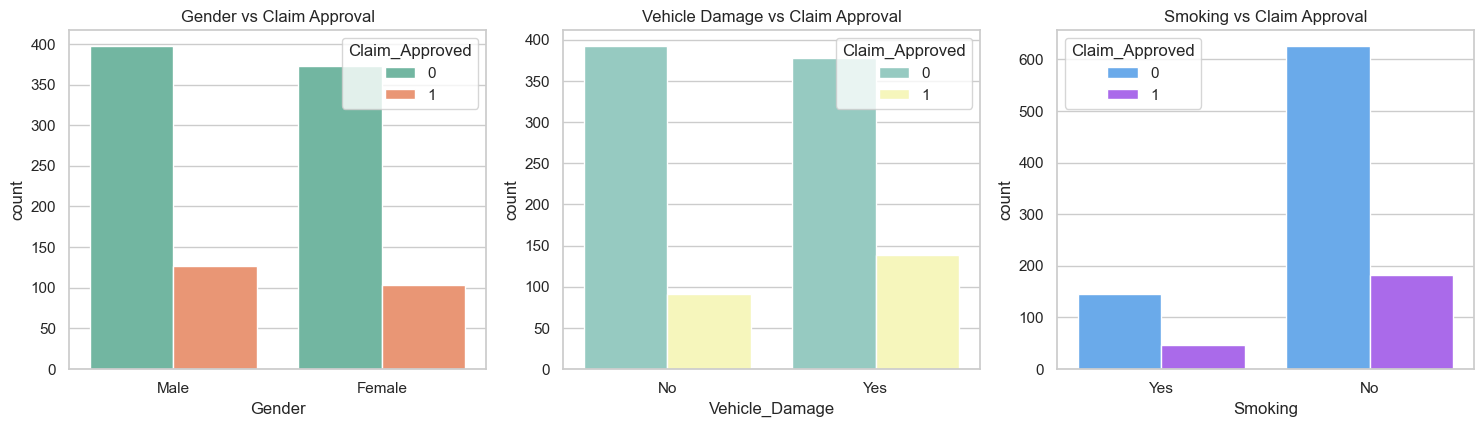

In [103]:
# -----------------------------------
# Step 3: Visualizations – Part 1 (Categorical)
# -----------------------------------

# Plot distribution of Claim Approval
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Claim_Approved')
plt.title("Distribution of Claim Approval")
plt.xlabel("Claim Approved (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Set figure size for multiple plots
plt.figure(figsize=(15, 8))

# Gender vs Claim Approval
plt.subplot(2, 3, 1)
sns.countplot(x='Gender', data=df, hue='Claim_Approved', palette='Set2')
plt.title("Gender vs Claim Approval")

# Vehicle Damage vs Claim Approval
plt.subplot(2, 3, 2)
sns.countplot(x='Vehicle_Damage', data=df, hue='Claim_Approved', palette='Set3')
plt.title("Vehicle Damage vs Claim Approval")

# Smoking vs Claim Approval
plt.subplot(2, 3, 3)
sns.countplot(x='Smoking', data=df, hue='Claim_Approved', palette='cool')
plt.title("Smoking vs Claim Approval")

plt.tight_layout()
plt.show()


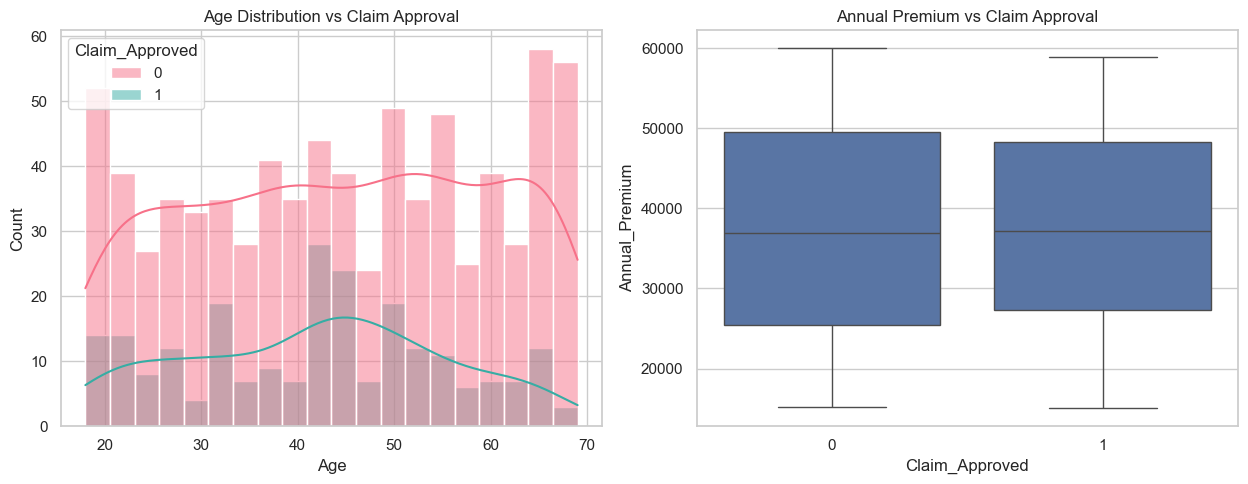

In [104]:
# -----------------------------------
# Step 4: Visualizations – Part 2 (Numeric)
# -----------------------------------
plt.figure(figsize=(19, 5))

# Age Distribution
plt.subplot(1, 3, 1)
sns.histplot(data=df, x="Age", hue="Claim_Approved", kde=True, bins=20, palette='husl')
plt.title("Age Distribution vs Claim Approval")

# Annual Premium Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='Claim_Approved', y='Annual_Premium')
plt.title("Annual Premium vs Claim Approval")

plt.tight_layout()
plt.show()

In [105]:
# -----------------------------------
# Step 5: Data Preprocessing
# -----------------------------------
# Create a copy of the original dataset
df_encoded = df.copy()

# Label Encoding for binary categorical columns
le = LabelEncoder()
df_encoded['Gender'] = le.fit_transform(df_encoded['Gender'])                # Male=1, Female=0
df_encoded['Smoking'] = le.fit_transform(df_encoded['Smoking'])              # Yes=1, No=0
df_encoded['Vehicle_Damage'] = le.fit_transform(df_encoded['Vehicle_Damage'])# Yes=1, No=0

# One-hot encoding for multi-category columns
df_encoded = pd.get_dummies(df_encoded, columns=['Region', 'Policy_Sales_Channel'], drop_first=True)

print(df_encoded.head(2))  # Check encoded data

   Age  Gender   BMI  Smoking  ...  Region_South  Region_West  Policy_Sales_Channel_Call Center  Policy_Sales_Channel_Online
0   56       1  36.8        1  ...         False        False                              True                        False
1   69       1  29.1        0  ...         False        False                              True                        False

[2 rows x 14 columns]


In [106]:
# -----------------------------------
# Step 6: Model Preparation
# -----------------------------------
# Define target and features
y = df_encoded['Claim_Approved']
X = df_encoded.drop('Claim_Approved', axis=1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (800, 13)
Test shape: (200, 13)


In [107]:
# -----------------------------------
# Step 7: Model Training and Evaluation
# -----------------------------------
# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Accuracy: 0.765

Confusion Matrix:
 [[152   2]
 [ 45   1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.99      0.87       154
           1       0.33      0.02      0.04        46

    accuracy                           0.77       200
   macro avg       0.55      0.50      0.45       200
weighted avg       0.67      0.77      0.68       200

ROC-AUC Score: 0.5138339920948616


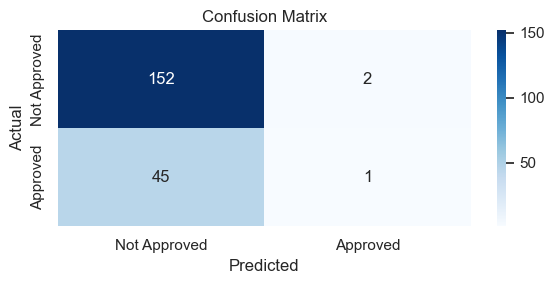

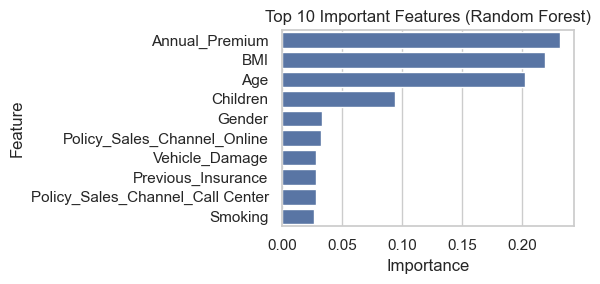

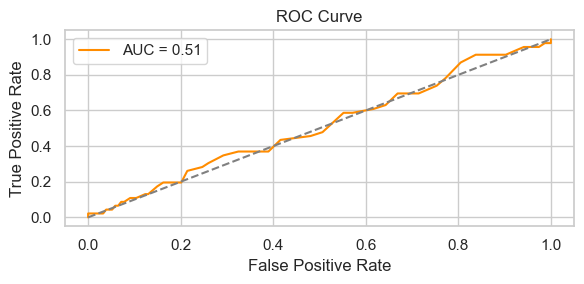

In [108]:
# -----------------------------------
# Step 8: Visual Evaluation
# -----------------------------------

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Approved", "Approved"],
            yticklabels=["Not Approved", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature Importance Plot
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10])
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()